# A simple autoencoder from scratch using the contrib layers of tensorflow

In [1]:
%matplotlib inline
import os
import socket
import pickle

import numpy as np
import pandas as pd
import tensorflow as tf

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
def cross_entropy(x_, x, offset=1e-7):
    with tf.name_scope('cross_entropy'):
        x__ = tf.clip_by_value(x_, offset, 1 - offset)
        return -tf.reduce_sum(x * tf.log(x__) + (1 - x) * tf.log(1 - x_), 1)
    
def kl_distance(mu, log_sigma):
    with tf.name_scope('KL_divergence'):
        return -0.5 * tf.reduce_sum(1 + 2 * log_sigma - mu**2 - tf.exp(2 * log_sigma), 1)
        
class VariationalAutoEncoder(object):
    DEFAULTS = {
        "batch_size": 128,
        "learning_rate": 5E-4,
        "dropout": 0.9,
        "lambda_l2_reg": 1E-5,
        "nonlinearity": tf.nn.elu,
        "squashing": tf.nn.sigmoid,
        "regularization": tf.contrib.layers.l2_regularizer,
        "mu": 0,
        "sigma": 1.,
    }
    RESTORE_KEY = "to_restore"
    
    def __init__(self, architecture=[], d_hyperparams={}, log_dir='./log'):
        self.architecture = architecture
        self.__dict__.update(VariationalAutoEncoder.DEFAULTS, **d_hyperparams)
        self.sesh = tf.Session()
        #TODO: decide if load a model or build a new one. For now, build it
        handles = self._build_graph()
        
        # In any case, make a collection of variables that are restore-able
        for handle in handles:
            tf.add_to_collection(VariationalAutoEncoder.RESTORE_KEY, handle)
            
        self.sesh.run(tf.global_variables_initializer())

        
        # Unpack the tuple of handles created by the builder
        (self.x_in, self.z_mean, self.z_log_sigma, self.x_reconstructed, self.z, 
               self.cost, self.global_step, self.train_op, self.merged_summaries) = handles
        
        # Initialize the filewriter and write the graph (tensorboard)
        
        self.writer = tf.summary.FileWriter(log_dir, self.sesh.graph)
        
    def _build_graph(self):
        # The architecture is definded here, using contrib layers
        # Tdodo: implement a compose_layers
        
        regularizer = self.regularization(self.lambda_l2_reg)
        #regularizer = None
        # the encoder
        x_in = tf.placeholder(tf.float32, shape=[None, self.architecture[0]], name='x_in')
        x = tf.layers.dense(x_in, 500, activation=self.nonlinearity, 
                            kernel_regularizer=regularizer,
                            name='enc_0')
        x = tf.layers.dropout(x, rate=self.dropout, name='drop_e0')
        x = tf.layers.dense(x, 500, activation=self.nonlinearity, 
                            kernel_regularizer=regularizer,
                            name='enc_1')
        x = tf.layers.dropout(x, rate=self.dropout, name='drop_e1')
        x = tf.layers.dense(x, 250, activation=self.nonlinearity, 
                            kernel_regularizer=regularizer,
                            name='enc_2')
        x = tf.layers.dropout(x, rate=self.dropout, name='drop_e2')
        x = tf.layers.dense(x, 50, activation=self.nonlinearity, 
                            kernel_regularizer=regularizer,
                            name='enc_3')
        x = tf.layers.dropout(x, rate=self.dropout, name='drop_e3')
#         for i, dim in enumerate(self.architecture[1:-1]):
#             print('Encoder: Creating fully connected layer with sizes: IN {} - SIZE {}'.format(x.shape, dim))
#             x = tf.layers.dense(x_in, dim, activation=self.nonlinearity, name='enc_{}'.format(i))
        
        # the latent space (separate the mean and the sigma)
        z_mean = tf.layers.dense(x, self.architecture[-1], activation=self.nonlinearity, name='z_mean') 
        z_log_sigma = tf.layers.dense(x, self.architecture[-1], activation=self.nonlinearity, name='z_log_sigma')
        print('Creating fully connected latent layers with sizes {}'.format(z_mean.shape))

        # The sample from the latent space with n(0,1)
        # With a little trick. Rathern than sampling N(z_mean, z_sigma), 
        # add a gaussian noise
        eps = tf.random_normal(tf.shape(z_log_sigma), 0, self.sigma, 
                               dtype=tf.float32, name='eps')
        
        z = tf.add(z_mean, eps * tf.exp(z_log_sigma), name='z')
        
        # decoder (from z to x_out)
        h = tf.layers.dense(z, 50, activation=self.nonlinearity, 
                            kernel_regularizer=regularizer,
                            name='dec_{}'.format(3))
        h = tf.layers.dropout(h, rate=self.dropout, name='drop_d3')
        h = tf.layers.dense(h, 250, activation=self.nonlinearity, 
                            kernel_regularizer=regularizer,
                            name='dec_{}'.format(2))
        h = tf.layers.dropout(h, rate=self.dropout, name='drop_d2')
        h = tf.layers.dense(h, 500, activation=self.nonlinearity, 
                            kernel_regularizer=regularizer,
                            name='dec_{}'.format(1))
        h = tf.layers.dropout(h, rate=self.dropout, name='drop_d1')
        h = tf.layers.dense(h, 500, activation=self.nonlinearity, 
                            kernel_regularizer=regularizer,
                            name='dec_{}'.format(0))
        h = tf.layers.dropout(h, rate=self.dropout, name='drop_d0')
#         for i, dim in enumerate(self.architecture[1:-1][::-1]):
#             print('Decoder: Creating fully connected layer with sizes: IN {} - SIZE {}'.format(h.shape, dim))
#             h = tf.layers.dense(h, dim, activation=self.nonlinearity, name='dec_{}'.format(i))
        print('Created decoder layers')
        # final reconstruction with squashing to [0, 1]
        y = tf.layers.dense(h, self.architecture[0], activation=self.squashing, 
                            kernel_regularizer=regularizer,
                            name='decoder')
        y = tf.layers.dropout(y, rate=self.dropout, name='drop_decoder')
        x_reconstructed = tf.identity(y, name='x_reconstructed')
        
        # reconstruction loss: cross-entropy
        rec_loss = cross_entropy(x_reconstructed, x_in)
        
        # KL divergence: information loss btw X and Z representations
        kl_loss = kl_distance(z_mean, z_log_sigma)
        
        # regularization loss
        l2_loss = tf.losses.get_regularization_loss()
        
        with tf.name_scope('cost'):
            cost = tf.reduce_sum(rec_loss + kl_loss, name='vae_cost') + l2_loss
            
        # append to summary
        with tf.name_scope('summaries'):
            with tf.name_scope('loss'):
                tf.summary.scalar('kl_loss', tf.reduce_sum(kl_loss, name='kl_scalar'))
                tf.summary.scalar('rec_loss', tf.reduce_sum(rec_loss, name='rl_scalar'))
                tf.summary.scalar('cost', cost)
                tf.summary.scalar('l2_loss', l2_loss)
                tf.summary.histogram('kl_hist', kl_loss)
                tf.summary.histogram('rec_hist', rec_loss)
        
        print('created all layers')
        # The optimization
        global_step = tf.Variable(0, trainable=False)
        with tf.name_scope('AdamOptimizer'):
            optimizer = tf.train.AdamOptimizer(self.learning_rate)
            # simple optimization
            # train_op = optimizer.minimize(cost, global_step=global_step, name='minimize_cost')
            # With clipped gradients:
            train_vars = tf.trainable_variables()
            grads_and_vars = optimizer.compute_gradients(cost, var_list=train_vars)
            
            clipped = []
            for grad, var in grads_and_vars:
                print('var {}'.format(var))
                print('grad {}'.format(grad))
                # add histograms of gradients, per variable (?)
#                 with tf.name_scope('summaries'):
#                     with tf.name_scope('gradients'):
#                         tf.summary.histogram(grad)
                clipped.append((tf.clip_by_value(grad, -5, 5), var))
            train_op = optimizer.apply_gradients(clipped, global_step=global_step, 
                                                name='minimize_cost')
        
        merged_summaries = tf.summary.merge_all()
        # return tuple of operations
        return(x_in, z_mean, z_log_sigma, x_reconstructed, z, 
               cost, global_step, train_op, merged_summaries)
        
    def encode(self, x):
        feed_dict = {self.x_in: x}
        return self.sesh.run([self.z_mean, self.z_log_sigma], feed_dict=feed_dict)
        
    def decode(self, z):
        feed_dict = {self.z: z}
        return self.sesh.run(self.x_reconstructed, feed_dict=feed_dict)
    
    def vae(self, x):
        feed_dict = {self.x_in: x}
        return self.sesh.run([self.x_reconstructed, self.z, self.z_log_sigma], 
                             feed_dict=feed_dict)
    
    def train(self, X, max_iter=np.inf, max_epochs=np.inf, cross_validate=True, verbose=True):
        try:
            err_train = 0
            
            while True:
                x, _ = X.train.next_batch(self.batch_size)
                feed_dict = {self.x_in: x}
                fetches = [self.x_reconstructed, self.cost, self.global_step, self.train_op]
                x_reconstructed, cost, i, _ = self.sesh.run(fetches, feed_dict=feed_dict)

                err_train += cost
                if i % 10 == 0:  # Record summaries and test-set accuracy
                    summary = self.sesh.run(self.merged_summaries, feed_dict=feed_dict)
                    self.writer.add_summary(summary, i)
                if i%1000 and verbose:
                    print('Round {}, loss {}'.format(i, cost))
                if i>=max_iter or X.train.epochs_completed >= max_epochs:
                    print("final avg cost (@ step {} = epoch {}): {}".format(
                            i, X.train.epochs_completed, err_train / i))
                    try:
                        self.writer.flush()
                        self.writer.close()
                    except(AttributeError):  # not logging
                        continue
                    break
                    
        except KeyboardInterrupt:
            print("final avg cost (@ step {} = epoch {}): {}".format(
                i, X.train.epochs_completed, err_train / i))
            print("------- Training end: {} -------\n".format(now))
            
        

## Use it with the mnist dataset

In [3]:
def load_mnist():
    from tensorflow.examples.tutorials.mnist import input_data
    return input_data.read_data_sets("./mnist_data")

def all_plots(model, mnist):
    if model.architecture[-1] == 2: # only works for 2-D latent
        print("Plotting in latent space...")
        plot_all_in_latent(model, mnist)

        print("Exploring latent...")
        plot.exploreLatent(model, nx=20, ny=20, range_=(-4, 4), outdir=PLOTS_DIR)
        for n in (24, 30, 60, 100):
            plot.exploreLatent(model, nx=n, ny=n, ppf=True, outdir=PLOTS_DIR,
                               name="explore_ppf{}".format(n))

    print("Interpolating...")
    interpolate_digits(model, mnist)

    print("Plotting end-to-end reconstructions...")
    plot_all_end_to_end(model, mnist)

    print("Morphing...")
    morph_numbers(model, mnist, ns=[9,8,7,6,5,4,3,2,1,0])

    print("Plotting 10 MNIST digits...")
    for i in range(10):
        plot.justMNIST(get_mnist(i, mnist), name=str(i), outdir=PLOTS_DIR)

def plot_all_in_latent(model, mnist):
    names = ("train", "validation", "test")
    datasets = (mnist.train, mnist.validation, mnist.test)
    for name, dataset in zip(names, datasets):
        plot.plotInLatent(model, dataset.images, dataset.labels, name=name,
                          outdir=PLOTS_DIR)
        
def interpolate_digits(model, mnist):
    imgs, labels = mnist.train.next_batch(100)
    idxs = np.random.randint(0, imgs.shape[0] - 1, 2)
    mus, _ = model.encode(np.vstack(imgs[i] for i in idxs))
    plot.interpolate(model, *mus, name="interpolate_{}->{}".format(
        *(labels[i] for i in idxs)), outdir=PLOTS_DIR)

def plot_all_end_to_end(model, mnist):
    names = ("train", "validation", "test")
    datasets = (mnist.train, mnist.validation, mnist.test)
    for name, dataset in zip(names, datasets):
        x, _ = dataset.next_batch(10)
        x_reconstructed = model.vae(x)
        plot.plotSubset(model, x, x_reconstructed, n=10, name=name,
                        outdir=PLOTS_DIR)

def morph_numbers(model, mnist, ns=None, n_per_morph=10):
    if not ns:
        import random
        ns = random.sample(range(10), 10) # non-in-place shuffle

    xs = np.squeeze([get_mnist(n, mnist) for n in ns])
    mus, _ = model.encode(xs)
    plot.morph(model, mus, n_per_morph=n_per_morph, outdir=PLOTS_DIR,
               name="morph_{}".format("".join(str(n) for n in ns)))

In [4]:
IMG_DIM = 28

ARCHITECTURE = [IMG_DIM**2, # 784 pixels
                500, 500, # intermediate encoding
                2] # latent space dims
                # 50]
# (and symmetrically back out again)

HYPERPARAMS = {
    "batch_size": 128,
    "learning_rate": 5E-4,
    "dropout": 0.1,
    "lambda_l2_reg": 1E-5,
    "nonlinearity": tf.nn.elu,
    "squashing": tf.nn.sigmoid
}

MAX_ITER = 2000#2**16
MAX_EPOCHS = np.inf

LOG_DIR = "./log"
METAGRAPH_DIR = "./out"
PLOTS_DIR = "./png"



In [5]:
v = VariationalAutoEncoder(ARCHITECTURE, HYPERPARAMS, log_dir=LOG_DIR)
#mnist = load_mnist()
#v.train(mnist, max_iter=MAX_ITER, max_epochs=MAX_EPOCHS, cross_validate=False, verbose=True)

Creating fully connected latent layers with sizes (?, 2)
Created decoder layers
created all layers
var <tf.Variable 'enc_0/kernel:0' shape=(784, 500) dtype=float32_ref>
grad Tensor("AdamOptimizer/gradients/AddN_12:0", shape=(784, 500), dtype=float32)
var <tf.Variable 'enc_0/bias:0' shape=(500,) dtype=float32_ref>
grad Tensor("AdamOptimizer/gradients/enc_0/BiasAdd_grad/tuple/control_dependency_1:0", shape=(500,), dtype=float32)
var <tf.Variable 'enc_1/kernel:0' shape=(500, 500) dtype=float32_ref>
grad Tensor("AdamOptimizer/gradients/AddN_11:0", shape=(500, 500), dtype=float32)
var <tf.Variable 'enc_1/bias:0' shape=(500,) dtype=float32_ref>
grad Tensor("AdamOptimizer/gradients/enc_1/BiasAdd_grad/tuple/control_dependency_1:0", shape=(500,), dtype=float32)
var <tf.Variable 'enc_2/kernel:0' shape=(500, 250) dtype=float32_ref>
grad Tensor("AdamOptimizer/gradients/AddN_10:0", shape=(500, 250), dtype=float32)
var <tf.Variable 'enc_2/bias:0' shape=(250,) dtype=float32_ref>
grad Tensor("AdamOpti

In [6]:
mnist = load_mnist()
v.train(mnist, max_iter=MAX_ITER, max_epochs=MAX_EPOCHS, cross_validate=False, verbose=True)

Extracting ./mnist_data/train-images-idx3-ubyte.gz
Extracting ./mnist_data/train-labels-idx1-ubyte.gz
Extracting ./mnist_data/t10k-images-idx3-ubyte.gz
Extracting ./mnist_data/t10k-labels-idx1-ubyte.gz
Round 1, loss 69777.2890625
Round 2, loss 70216.0
Round 3, loss 69708.6796875
Round 4, loss 69581.421875
Round 5, loss 69160.65625
Round 6, loss 68749.140625
Round 7, loss 67470.703125
Round 8, loss 66261.171875
Round 9, loss 64700.6328125
Round 10, loss 62768.15625
Round 11, loss 60443.30078125
Round 12, loss 57779.1171875
Round 13, loss 53864.92578125
Round 14, loss 49801.15234375
Round 15, loss 45949.9921875
Round 16, loss 42603.515625
Round 17, loss 38307.859375
Round 18, loss 36320.1796875
Round 19, loss 33398.62890625
Round 20, loss 30913.74609375
Round 21, loss 31288.09765625
Round 22, loss 30972.36328125
Round 23, loss 30709.64453125
Round 24, loss 29873.48828125
Round 25, loss 31422.859375
Round 26, loss 30018.365234375
Round 27, loss 29646.51171875
Round 28, loss 29902.25585937

Round 278, loss 26809.568359375
Round 279, loss 26526.5234375
Round 280, loss 26410.7734375
Round 281, loss 26694.04296875
Round 282, loss 26852.5703125
Round 283, loss 27288.845703125
Round 284, loss 25683.552734375
Round 285, loss 26462.69921875
Round 286, loss 27592.3984375
Round 287, loss 26959.09375
Round 288, loss 25996.45703125
Round 289, loss 27196.966796875
Round 290, loss 27184.0703125
Round 291, loss 27845.37890625
Round 292, loss 26719.82421875
Round 293, loss 26805.640625
Round 294, loss 26245.6328125
Round 295, loss 26931.80078125
Round 296, loss 26889.5546875
Round 297, loss 25943.572265625
Round 298, loss 27032.80859375
Round 299, loss 27375.830078125
Round 300, loss 26291.5
Round 301, loss 27447.3046875
Round 302, loss 26611.08984375
Round 303, loss 26092.248046875
Round 304, loss 26069.4453125
Round 305, loss 26964.51953125
Round 306, loss 26131.69140625
Round 307, loss 26092.427734375
Round 308, loss 26095.330078125
Round 309, loss 27062.802734375
Round 310, loss 267

Round 580, loss 27054.326171875
Round 581, loss 26906.05078125
Round 582, loss 27968.30078125
Round 583, loss 27371.0078125
Round 584, loss 27513.7421875
Round 585, loss 26620.712890625
Round 586, loss 26497.27734375
Round 587, loss 26336.533203125
Round 588, loss 26117.330078125
Round 589, loss 25495.3046875
Round 590, loss 26356.42578125
Round 591, loss 26216.970703125
Round 592, loss 25920.525390625
Round 593, loss 26003.619140625
Round 594, loss 25833.04296875
Round 595, loss 26243.38671875
Round 596, loss 26014.55859375
Round 597, loss 26251.30859375
Round 598, loss 25465.1484375
Round 599, loss 26747.77734375
Round 600, loss 24820.615234375
Round 601, loss 25891.134765625
Round 602, loss 26095.625
Round 603, loss 25747.125
Round 604, loss 25257.763671875
Round 605, loss 26060.357421875
Round 606, loss 26361.05859375
Round 607, loss 25248.11328125
Round 608, loss 24573.06640625
Round 609, loss 25297.37890625
Round 610, loss 26280.744140625
Round 611, loss 25350.265625
Round 612, l

Round 860, loss 22244.384765625
Round 861, loss 22151.126953125
Round 862, loss 22351.103515625
Round 863, loss 21950.412109375
Round 864, loss 20854.08203125
Round 865, loss 22897.232421875
Round 866, loss 22890.40625
Round 867, loss 22659.23828125
Round 868, loss 23191.64453125
Round 869, loss 22803.951171875
Round 870, loss 22913.162109375
Round 871, loss 22323.109375
Round 872, loss 22413.509765625
Round 873, loss 21506.529296875
Round 874, loss 22418.962890625
Round 875, loss 23393.89453125
Round 876, loss 23538.126953125
Round 877, loss 22976.201171875
Round 878, loss 23269.216796875
Round 879, loss 22063.625
Round 880, loss 21886.322265625
Round 881, loss 22537.470703125
Round 882, loss 21894.31640625
Round 883, loss 22578.75
Round 884, loss 22485.939453125
Round 885, loss 22782.501953125
Round 886, loss 22424.556640625
Round 887, loss 21507.482421875
Round 888, loss 21695.060546875
Round 889, loss 22134.357421875
Round 890, loss 22674.736328125
Round 891, loss 22482.201171875
R

Round 1126, loss 21828.501953125
Round 1127, loss 21611.09375
Round 1128, loss 22314.56640625
Round 1129, loss 22120.099609375
Round 1130, loss 22185.298828125
Round 1131, loss 21708.537109375
Round 1132, loss 22318.083984375
Round 1133, loss 22280.58984375
Round 1134, loss 22510.416015625
Round 1135, loss 22453.732421875
Round 1136, loss 22144.30078125
Round 1137, loss 22337.91796875
Round 1138, loss 22655.67578125
Round 1139, loss 22242.998046875
Round 1140, loss 21857.24609375
Round 1141, loss 22152.642578125
Round 1142, loss 22079.8046875
Round 1143, loss 23164.103515625
Round 1144, loss 22518.37109375
Round 1145, loss 21826.166015625
Round 1146, loss 21966.7890625
Round 1147, loss 21984.017578125
Round 1148, loss 22856.8203125
Round 1149, loss 21391.439453125
Round 1150, loss 21391.099609375
Round 1151, loss 22155.958984375
Round 1152, loss 22330.392578125
Round 1153, loss 21769.041015625
Round 1154, loss 22572.55078125
Round 1155, loss 22161.1953125
Round 1156, loss 21682.4570312

Round 1406, loss 22411.3671875
Round 1407, loss 22135.744140625
Round 1408, loss 21637.423828125
Round 1409, loss 21310.251953125
Round 1410, loss 22588.607421875
Round 1411, loss 21293.798828125
Round 1412, loss 21690.591796875
Round 1413, loss 22340.578125
Round 1414, loss 21172.45703125
Round 1415, loss 22306.125
Round 1416, loss 21616.599609375
Round 1417, loss 22532.669921875
Round 1418, loss 21466.873046875
Round 1419, loss 21757.732421875
Round 1420, loss 22326.525390625
Round 1421, loss 22257.1796875
Round 1422, loss 22317.947265625
Round 1423, loss 22209.537109375
Round 1424, loss 21932.28515625
Round 1425, loss 22615.8359375
Round 1426, loss 22278.478515625
Round 1427, loss 22696.56640625
Round 1428, loss 20689.2734375
Round 1429, loss 21766.447265625
Round 1430, loss 22215.57421875
Round 1431, loss 22051.853515625
Round 1432, loss 22977.49609375
Round 1433, loss 22050.412109375
Round 1434, loss 22056.994140625
Round 1435, loss 22227.146484375
Round 1436, loss 21563.462890625

Round 1680, loss 22292.48046875
Round 1681, loss 22170.412109375
Round 1682, loss 22203.318359375
Round 1683, loss 21751.587890625
Round 1684, loss 22745.771484375
Round 1685, loss 21473.802734375
Round 1686, loss 21786.466796875
Round 1687, loss 21213.796875
Round 1688, loss 21204.40625
Round 1689, loss 21325.771484375
Round 1690, loss 21632.61328125
Round 1691, loss 21669.962890625
Round 1692, loss 20753.052734375
Round 1693, loss 21753.57421875
Round 1694, loss 21056.5859375
Round 1695, loss 21620.8046875
Round 1696, loss 21957.533203125
Round 1697, loss 21689.697265625
Round 1698, loss 22514.298828125
Round 1699, loss 21740.810546875
Round 1700, loss 21732.015625
Round 1701, loss 21815.884765625
Round 1702, loss 21198.197265625
Round 1703, loss 21545.939453125
Round 1704, loss 22263.986328125
Round 1705, loss 21872.900390625
Round 1706, loss 22024.259765625
Round 1707, loss 21701.537109375
Round 1708, loss 21877.056640625
Round 1709, loss 20931.888671875
Round 1710, loss 20465.6425

Round 1963, loss 21447.8984375
Round 1964, loss 21393.3671875
Round 1965, loss 21342.755859375
Round 1966, loss 22953.32421875
Round 1967, loss 20821.25
Round 1968, loss 22852.072265625
Round 1969, loss 21790.41796875
Round 1970, loss 21295.294921875
Round 1971, loss 21552.58203125
Round 1972, loss 22526.09375
Round 1973, loss 22853.9921875
Round 1974, loss 20744.12109375
Round 1975, loss 19619.02734375
Round 1976, loss 21783.23046875
Round 1977, loss 20980.23828125
Round 1978, loss 20973.935546875
Round 1979, loss 21067.734375
Round 1980, loss 21465.138671875
Round 1981, loss 20646.177734375
Round 1982, loss 21287.67578125
Round 1983, loss 21098.24609375
Round 1984, loss 22098.02734375
Round 1985, loss 21563.1015625
Round 1986, loss 21839.919921875
Round 1987, loss 21104.794921875
Round 1988, loss 21806.107421875
Round 1989, loss 21012.1171875
Round 1990, loss 21860.83203125
Round 1991, loss 21927.482421875
Round 1992, loss 20101.28515625
Round 1993, loss 22249.26171875
Round 1994, lo

In [7]:
xx,yy = mnist.test.next_batch(1000)
xr, zm, zs = v.vae(xx)

In [8]:
xx.shape

(1000, 784)

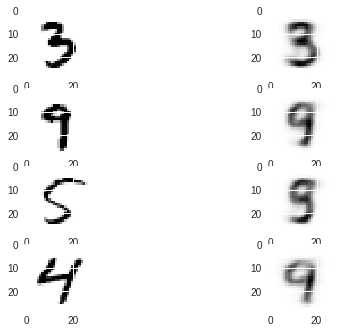

In [9]:
examples_plot = [0, 4, 6, 10]

for i, j in enumerate(examples_plot):
    plt.subplot(len(examples_plot), 2, (i+1)*2-1)
    plt.imshow(xx[j].reshape(28, 28))
    plt.subplot(len(examples_plot), 2, (i+1)*2)
    plt.imshow(xr[j].reshape(28, 28))

In [10]:
reconstruction = pd.DataFrame(np.c_[zm, yy], columns=['e1', 'e2', 'd'])

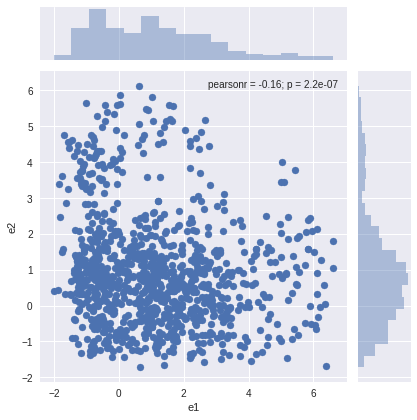

In [11]:
sns.jointplot(x="e1", y="e2", data=reconstruction);

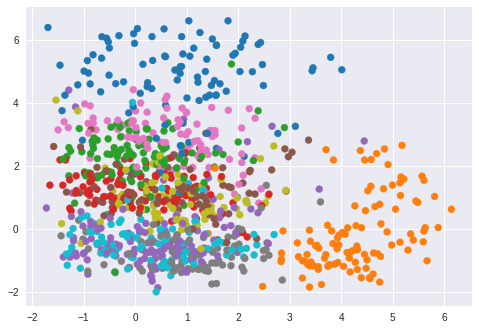

In [14]:
plt.scatter(reconstruction['e2'], reconstruction['e1'], 
            c=reconstruction['d'], 
            cmap = 'tab10')

In [ ]:
kwargs={}
classes = set(yy)
colormap = plt.cm.rainbow(np.linspace(0, 1, len(classes)))
kwargs['c'] = [colormap[i] for i in yy]
plt.scatter(zm[:,1], zm[:,0], **kwargs)

In [ ]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette())

In [ ]:
cmap